# Met Eireann wind speed analysis
### Programming for Data Analytics Project
Author: Vanessa de Oliveira Lyra


For this project, one Met Éireann weather station per county was selected based on windspeed data availability:  
Mace Head (Galway)  
Oak Park (Carlow)  
Shannon Airport (Clare)  
Dublin Airport (Dublin)  
Ballyhaise (Cavan)  
Mullingar (Westmeath)  
Dunsany (Meath)  
Gurteen (Tipperary)  
Malin Head (Donegal)  
Johnstown Castle (Wexford)  
Mount Dillon (Roscommon)  
Valentia Observatory (Kerry)  
Cork Airport (Cork)  
Ireland West Knock Airport (Mayo)  

Weather stations and wind data: https://www.met.ie/climate/available-data/historical-data

Importing libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

Database connection and data fetching

In [24]:
# Connecting to SQLite and creating database file
conn = sqlite3.connect("windspeed.db")

# Reading .csv file into a dataframe using semicolon separator
df_cork = pd.read_csv("datasets/dly3904_cork.csv",skiprows=24)
df_oakpark = pd.read_csv("datasets/dly375_oak_park.csv",skiprows=24)
df_shannon = pd.read_csv("datasets/dly518_shannon.csv",skiprows=24)
df_dublin = pd.read_csv("datasets/dly532_dublin.csv",skiprows=24)
df_ballyhaise = pd.read_csv("datasets/dly675_ballyhaise.csv",skiprows=24)
df_mullingar = pd.read_csv("datasets/dly875_mullingar.csv",skiprows=24)
df_dunsany = pd.read_csv("datasets/dly1375_dunsany.csv",skiprows=24)
df_gurteen = pd.read_csv("datasets/dly1475_gurteen.csv",skiprows=24)
df_malin = pd.read_csv("datasets/dly1575_malin_head.csv",skiprows=24)
df_johnstown = pd.read_csv("datasets/dly1775_johnstown.csv",skiprows=24)
df_mtdillon = pd.read_csv("datasets/dly1975_mt_dillon.csv",skiprows=24)
df_valentia = pd.read_csv("datasets/dly2275_valentia.csv",skiprows=24)
df_mace = pd.read_csv("datasets/dly275_mace_head.csv",skiprows=24)
df_knock = pd.read_csv("datasets/dly4935_knock_airport.csv",skiprows=24)

# Check first 5 lines of data for reference
df_cork.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,...,ind.5,hg,sun,dos,soil,pe,evap,smd_wd,smd_md,smd_pd
0,01-jan-1962,0,2.8,1,-2.5,,,8,,999.6,...,0,24,,0,,,,,,
1,02-jan-1962,0,2.8,1,-3.7,,,8,,1005.8,...,0,10,,0,,,,,,
2,03-jan-1962,0,2.3,1,-3.8,,,8,,1007.8,...,0,13,,0,,,,,,
3,04-jan-1962,0,6.6,0,0.6,,,8,,1007.8,...,0,12,,0,,,,,,
4,05-jan-1962,0,9.3,0,0.6,,,8,,1002.2,...,0,29,,0,,,,,,


In [25]:
# Mapping CSV filepaths
weather_files = {
    "cork": "datasets/dly3904_cork.csv",
    "oakpark": "datasets/dly375_oak_park.csv",
    "shannon": "datasets/dly518_shannon.csv",
    "dublin": "datasets/dly532_dublin.csv",
    "ballyhaise": "datasets/dly675_ballyhaise.csv",
    "mullingar": "datasets/dly875_mullingar.csv",
    "dunsany": "datasets/dly1375_dunsany.csv",
    "gurteen": "datasets/dly1475_gurteen.csv",
    "malin": "datasets/dly1575_malin_head.csv",
    "johnstown": "datasets/dly1775_johnstown.csv",
    "mtdillon": "datasets/dly1975_mt_dillon.csv",
    "valentia": "datasets/dly2275_valentia.csv",
    "mace": "datasets/dly275_mace_head.csv",
    "knock": "datasets/dly4935_knock_airport.csv"}

# Dictionary to store data
df_weather = {}

# For loop to read CSV files
for key, value in weather_files.items():
    df_weather[key] = pd.read_csv(value, skiprows=24) 

# Printing head for reference
# print(df_cork.head())

##### References:
Skiprows function: https://stackoverflow.com/questions/20637439/skip-rows-during-csv-import-pandas   
Writing data to SQlite: https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index  
Importing multiple files: https://stackoverflow.com/questions/56155629/reading-multiple-csv-files-with-different-names-using-python-dictionary-in-a-for

In [26]:
# Print headers for reference
# headers = df.columns.tolist()
# headers

Cleaning up dataset data

In [27]:
# List of columns from dataset to be dropped
drop_columns = ["ind","maxtp","ind.1","mintp","igmin","gmin","ind.2","rain","cbl","ind.3","ind.4","ind.5","sun","dos","soil","pe","evap","smd_wd","smd_md","smd_pd"]

# Loop over all stations
for weather_files, df in df_weather.items():
    # Drop unwanted columns
    df.drop(columns=drop_columns, inplace=True, errors="ignore")
    
    # Normalizing date column
    # Removing white spaces from data using stip()
    # Converting data to datetime, coerce will replace any invalid dates with NaT
    df["date"] = df["date"].astype(str).str.strip()
    df["date"] = pd.to_datetime(df["date"], format="%d-%b-%Y", errors="coerce")
    
    # Convert dataset columns to numeric values using for loop
    for col in ["wdsp", "hm", "hg", "ddhm"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Update the dictionary with the cleaned DataFrame
    df_weather[weather_files] = df
    
    # Writing clean data to database
    df.to_sql(f"{weather_files}_data", conn, if_exists="replace", index=False)

# Example: print Cork head after cleaning
print(df_weather["cork"].head())


        date  wdsp    hm  ddhm  hg
0 1962-01-01   9.2  14.0   340  24
1 1962-01-02   5.9   9.0   340  10
2 1962-01-03   6.7   9.0   360  13
3 1962-01-04   4.5   9.0   310  12
4 1962-01-05  12.7  21.0   240  29


##### References
Remove whitespaces from date: https://medium.com/@amit25173/how-to-remove-whitespace-from-strings-in-pandas-bfd9acdc55f3  
Converting datetime: https://pbpython.com/pandas_dtypes.html  
Convert data to numeric values https://kajodata.com/en/knowledge-base-excel-sql-python/knowledge-base-python-tech-skillshow-pandas-to_numeric-works-in-python-examples-mmk/  
Dates showing as NaT after claening data updated date format from %d-%b-%y to %d-%b-%Y to handle 4-digits year: https://medium.com/@codecorecomputercenter/python-date-formats-a-comprehensive-guide-c6ed0224980b     
For loop convert columns to numeric: https://stackoverflow.com/questions/50456153/use-to-numeric-on-certain-columns-only-in-pandas  

Wind Speed Statistics per location

In [28]:
# List of stations you want to analyze
all_stations = ["cork", "oakpark", "shannon", "dublin", "ballyhaise","mullingar", "dunsany", "gurteen", "malin", "johnstown","mtdillon", "valentia", "mace", "knock"]

# Dictionary to store stats
all_stats = {}

# Loop through stations, retrieving statistics using only relevant .describe() results
for key in all_stations:
    all_stats[key] = df_weather[key][["wdsp"]].describe().loc[["mean", "std", "min", "max"]]

# Concatenating data side by side (axis=1) for better visualization, keys are column/station names
windspeed_stats = pd.concat(all_stats.values(), axis=1, keys=all_stats.keys())

# Removing unecessary header wdsp
windspeed_stats.columns = windspeed_stats.columns.droplevel(1)

# Round numbers, show one decimal
windspeed_stats = windspeed_stats.round(1)

# Printing result
print(windspeed_stats)

      cork  oakpark  shannon  dublin  ballyhaise  mullingar  dunsany  gurteen  \
mean  10.3      7.4      9.6    10.2         6.4        7.3      7.9      8.2   
std    4.4      3.5      4.4     4.6         2.9        3.6      3.5      3.6   
min    0.0      0.2      0.0     0.0         0.2        0.0      0.6      0.2   
max   35.2     23.4     40.8    35.5        20.1       27.9     23.6     24.3   

      malin  johnstown  mtdillon  valentia  mace  knock  
mean   15.2        8.5       7.0      10.1  14.4    9.4  
std     6.5        3.5       3.2       4.9   6.5    3.9  
min     0.2        0.1       0.2       0.3   0.1    0.0  
max    44.8       23.5      96.8      38.2  41.5   26.8  


##### References

Filtering df.describe(): https://stackoverflow.com/questions/19124148/modify-output-from-python-pandas-describe  
Concatenating statistics: https://pandas.pydata.org/docs/user_guide/merging.html  
Removing extra column "wdsp" from final table: https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index  
Rounding column values: https://stackoverflow.com/questions/26133538/round-a-single-column-in-pandas

Monthly windspeed patterns

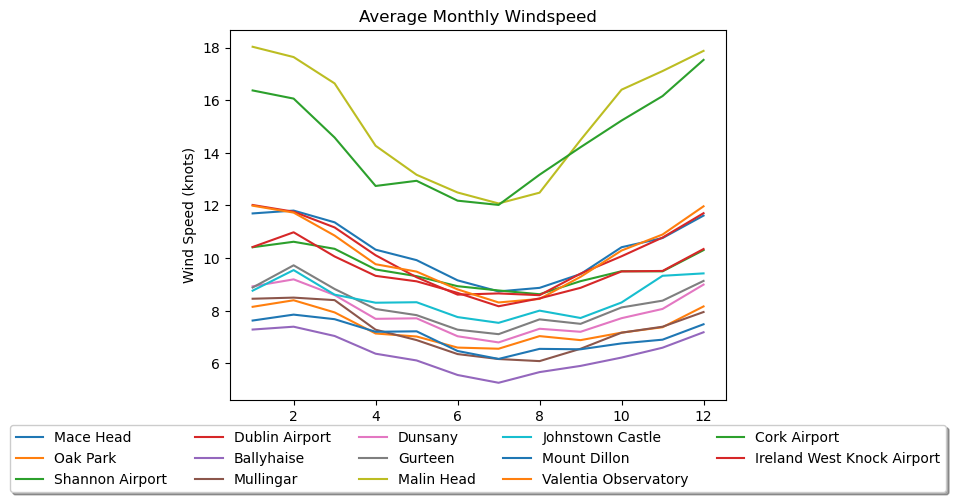

In [29]:
# List of stations for plot labels
labels = ["Mace Head", "Oak Park", "Shannon Airport", "Dublin Airport","Ballyhaise", "Mullingar", "Dunsany", "Gurteen", "Malin Head","Johnstown Castle", "Mount Dillon", "Valentia Observatory",
          "Cork Airport", "Ireland West Knock Airport"]

# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    monthly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.month)["wdsp"].mean()
    
    # Ploting lines
    plt.plot(monthly_mean, label=label)

    # Printstatement for testing
    # print(monthly_mean)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Average Monthly Windspeed")
plt.xlabel("Month")
plt.ylabel("Wind Speed (knots)")
plt.show()

##### References
Legend position: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

Yearly windspeed patterns

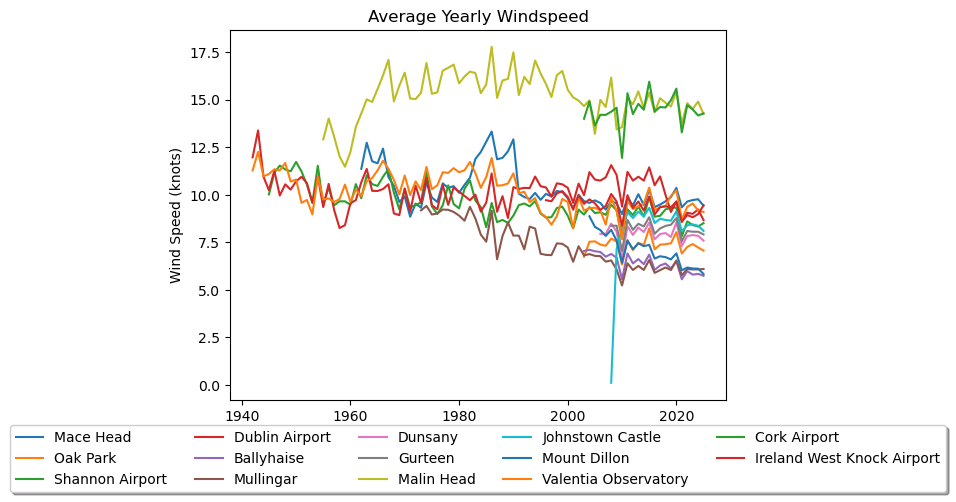

In [30]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    yearly_mean = df_weather[station].groupby(df_weather[station]["date"].dt.year)["wdsp"].mean()
    
    # Ploting lines
    plt.plot(yearly_mean, label=label)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Average Yearly Windspeed")
plt.xlabel("Year")
plt.ylabel("Wind Speed (knots)")
plt.show()

Wind Power

Wind power calculation: 

Power (W) = 1/2 x ρ x A x v3

Power = Watts
ρ = density of the air 1.225 kg/m3
A = cross-sectional area of the wind in m2
v = velocity of the wind in m/s

In [31]:
for key in all_stations:
    df = df_weather[key]
    # Converting windspeed in knots to m/s
    df["ms_wdsp"] = df["wdsp"] * 0.51444
    
    # Calculating wind power to all stations
    df["wind_power"] = (0.5 * 1.255 * (df["ms_wdsp"] ** 3))

    df.to_sql(f"{key}_data",conn, if_exists="replace", index = False)

# Dictionary to store wind power stats
wdpw_stats = {}

# Loop through stations, retrieving statistics using only relevant .describe() results
for key in all_stations:
    wdpw_stats[key] = df_weather[key][["wind_power"]].describe().loc[["mean", "std", "min", "max"]]

# Concatenating data side by side (axis=1) for better visualization, keys are column/station names
wdpw_stats_all = pd.concat(wdpw_stats.values(), axis=1, keys=wdpw_stats.keys())

# Removing unecessary header
wdpw_stats_all.columns = wdpw_stats_all.columns.droplevel(1)

# Round numbers, show one decimal
wdpw_stats_all = wdpw_stats_all.round(1)

# Printing result
print(wdpw_stats_all)

        cork  oakpark  shannon  dublin  ballyhaise  mullingar  dunsany  \
mean   152.0     60.4    129.6   150.3        37.1       59.7     70.9   
std    217.5     96.7    199.8   210.2        52.8       94.0    100.9   
min      0.0      0.0      0.0     0.0         0.0        0.0      0.0   
max   3726.0   1094.6   5802.3  3822.1       693.8     1855.4   1122.9   

      gurteen   malin  johnstown  mtdillon  valentia    mace   knock  
mean     77.0   476.6       80.6      57.9     159.4   426.1   111.6  
std     106.4   608.8      102.8     883.2     234.1   586.2   148.3  
min       0.0     0.0        0.0       0.0       0.0     0.0     0.0  
max    1225.8  7681.6     1108.7   77489.7    4762.2  6106.1  1644.5  


In [32]:
# Debugging line, checking if calculated widspeed and wind power are in the database
# pd.read_sql("PRAGMA table_info(cork_data);", conn)

##### References: 
Convert windspeed to m/s: https://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-pythonhttps://datascience.stackexchange.com/questions/131732/wind-power-data-analysis-python  
Wind power calculation:https://www.e-education.psu.edu/emsc297/node/649#:~:text=The%20power%20in%20the%20wind%20at%206%20m/s%20is,MW%20(27%20times%20as%20large)  
Debugging line: https://stackoverflow.com/questions/66897013/sqlite-how-to-return-the-output-of-pragma-table-info-in-a-pandas-dataframe

Operational wind speed for wind farms

Wind turbine limits:  
Cut-in: ~3 m/s  
Cut-out: ~25 m/s  
Rated: ~12 m/s  

In [33]:
# Creating a dictionary to store operation windspeed
operational_stats = {}

# Looping through weather station name from all_stations variable
for key in all_stations:
    # Retrieving DF for the station
    df = df_weather[key]
    
    # Filter operational windspeeds (in m/s) within cut-in and cut-out
    stats_limits = df[(df["ms_wdsp"] >= 3) & (df["ms_wdsp"] <= 25)]
    
    # Finding percentage  of operational windspeed
    # len(stats_limits): how amny times windspeed was within operational range
    # len(df): total number of windspeed records
    operational_perc = len(stats_limits) / len(df) * 100

    # Storing results in dictionary previously created
    operational_stats[key] = operational_perc

cols = ["Operational wind (%)"]
df_operational = (pd.DataFrame.from_dict(operational_stats, orient="index", columns=cols).round(1))

print(df_operational)

            Operational wind (%)
cork                        85.4
oakpark                     61.3
shannon                     78.5
dublin                      82.5
ballyhaise                  50.8
mullingar                   59.7
dunsany                     67.3
gurteen                     71.0
malin                       94.7
johnstown                   77.1
mtdillon                    60.3
valentia                    78.8
mace                        93.5
knock                       82.0


##### References: 

Wind turbine limits: https://www.nyserda.ny.gov/-/media/Project/Nyserda/Files/Publications/Research/Biomass-Solar-Wind/NY-Wind-Energy-Guide-1.pdf, pp.5  
pd.DataFrame.from_dict function: https://builtin.com/data-science/dictionary-to-dataframe#:~:text=pandas.-,DataFrame.,parsed%20as%20a%20DataFrame%20row.  

Monthly wind power

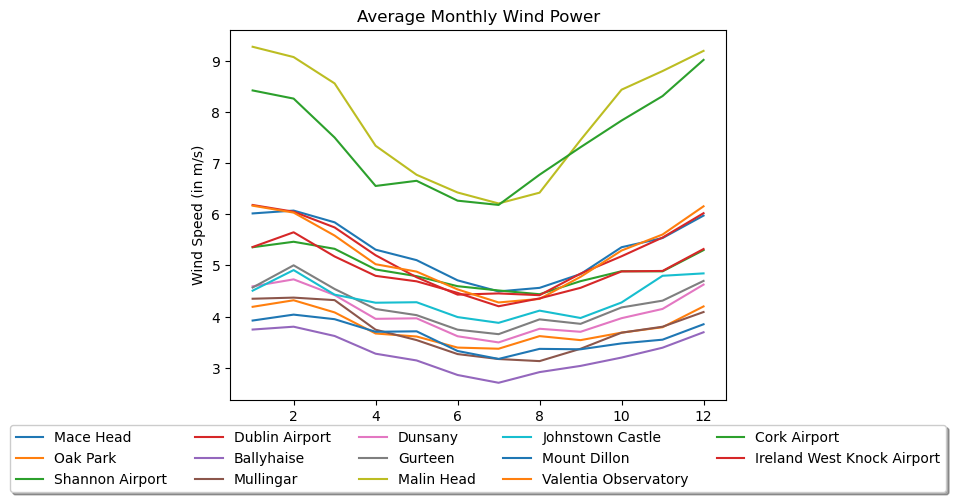

In [34]:
# Loop through stations
for i in range(len(all_stations)): #Loop throught the length of the data, number of times to loop through
    station = all_stations[i] # Get the weather station at a determined position, first loop will fetch data from position 0 and so on
    label = labels[i] # Same as above but with labels
    
    # Grouping data and windspeed and calculating men windspeed per month
    monthly_wdpw = df_weather[station].groupby(df_weather[station]["date"].dt.month)["ms_wdsp"].mean()
    
    # Ploting lines
    plt.plot(monthly_wdpw, label=label)

    # Printstatement for testing
    # print(monthly_mean)

# Adding legend, title, and axis labels
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.title("Average Monthly Wind Power")
plt.xlabel("Month")
plt.ylabel("Wind Speed (in m/s)")
plt.show()

In [35]:
pd.read_sql("SELECT ms_wdsp, wind_power FROM cork_data LIMIT 5;", conn)


,ms_wdsp,wind_power
0,4.732848,66.524467
1,3.035196,17.545831
2,3.446748,25.694628
3,2.314980,7.784943
4,6.533388,174.996387


Un-operational windpower frequency

In [50]:
unoperational_wdpw = {}

# Loop through all stations data
for key in all_stations:
    table_name = f"{key}_data"
    
    # Calculating unoperational windpower
    query = f""" SELECT 
    COUNT(CASE WHEN ms_wdsp < 3 THEN 1 END) * 100.0 / COUNT(*) AS light_wind_perc,
    COUNT(CASE WHEN ms_wdsp > 25 THEN 1 END) * 100.0 / COUNT(*) AS strong_wind_perc
    FROM {table_name};"""
    
    result = pd.read_sql(query, conn)
    unoperational_wdpw[key] = [round(result.loc[0, "light_wind_perc"],1),
                                 round(result.loc[0, "strong_wind_perc"],1)]
    
    

SQL count query: https://www.interviewquery.com/p/sql-count-case-when
Fixing error "unterminated f-string literal": https://stackoverflow.com/questions/68025686/how-to-do-python-f-strings-in-triple-quotes